In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,spearmanr
from datetime import datetime
from sklearn.metrics import mean_squared_error 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.distributions import empirical_distribution
#My stuff starts In[37]

In [2]:
plPrice = pd.read_csv('plPrice17-19.csv')
plPrice.drop(columns = ['Hong Kong 8:30','Hong Kong 14:00','New York 9:30'],inplace = True)
plPrice.rename(columns = {'London 09:00':'Price'},inplace= True)
plPrice.dropna(how='any',inplace = True)
plPrice.to_csv('plPrice17-20Updated.csv')
plPrice['Date'] = pd.to_datetime(plPrice['Date'])
plPrice=plPrice[plPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

In [3]:
FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]

simulatedFTSE = pd.read_csv('fullSimulatedFTSEPrice.csv')
simulatedFTSE.rename(columns = {'Unnamed: 0':'Date'},inplace = True)
simulatedFTSE['Date'] = pd.to_datetime(simulatedFTSE['Date'])


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)


In [4]:
def tiltFTSE(tilt):
    #iterates over quarter in period
    for idx, quarter in enumerate(quarterNames):
        #gets index (trading days) for each quarter
        index = FTSE[(FTSE['Date'] >= quarterCutOffDates[idx]) & (FTSE['Date'] < quarterCutOffDates[idx+1])].Date.values

        #imports data for that quarter
        stockWeightsOpen = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Open.csv'.format(quarter))
        stockWeightsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockWeightsClose = pd.read_csv(r'companyWeightsEachQuarter/companyWeights{0}Close.csv'.format(quarter))
        stockWeightsClose.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsOpen = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Open.csv'.format(quarter))
        totalMCsOpen.drop(columns = 'Unnamed: 0', inplace = True)

        totalMCsClose = pd.read_csv(r'totalMarketCapsEachQuarter/totalMarketCaps{0}Close.csv'.format(quarter))
        totalMCsClose.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterOpen = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Open.csv'.format(quarter))
        stockMarketCapsEachQuarterOpen.drop(columns = 'Unnamed: 0', inplace = True)

        stockMarketCapsEachQuarterClose = pd.read_csv(r'companyMarketCapsEachQuarter/companyMarketCaps{0}Close.csv'.format(quarter))
        stockMarketCapsEachQuarterClose.drop(columns = 'Unnamed: 0', inplace = True)

        #iterates over each stock in the FTSE that quarter
        for stock in FTSEStocksEachQuarter[quarter]:
            #adds tilt from aray to the company weight
            stockWeightsOpen[stock] = stockWeightsOpen[stock].add(tilt.loc[stock][0])
            stockWeightsClose[stock] = stockWeightsClose[stock].add(tilt.loc[stock][0])

        #if weight is <0 then set to 0
        stockWeightsOpen[stockWeightsOpen < 0] = 0
        stockWeightsClose[stockWeightsClose < 0] = 0

        #calculates effective market caps using new weight and old market caps 
        newMarketCapsOpen = stockWeightsOpen*stockMarketCapsEachQuarterOpen.values
        newMarketCapsClose = stockWeightsClose*stockMarketCapsEachQuarterClose.values

        #calculates new total market cap each day
        newTotalMarketCapsOpen = newMarketCapsOpen.sum(axis=1).to_frame()
        newTotalMarketCapsClose = newMarketCapsClose.sum(axis=1).to_frame()

        #calculates index divisor to make sure price stays continuous over the change in quarter
        if idx == 0:
            #for the first quarter the reference price is the real FTSE price from that day - abitrary starting point
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/(FTSE[FTSE['Date'] == quarterCutOffDates[idx]]['Open'].values[0])
        else:
            indexDivisorForQuarter = newTotalMarketCapsOpen.values[0][0]/FTSEPriceQuarterly['Close'].values[-1]


        #calculates new tilted price using index divisor and tilted market caps

        FTSEPriceQuarterly = newTotalMarketCapsOpen.divide(indexDivisorForQuarter).set_index(index, drop=True)
        FTSEPriceQuarterly.rename(columns={0:"Open"}, inplace=True)
        FTSEPriceQuarterly['Close'] = newTotalMarketCapsClose.divide(indexDivisorForQuarter).set_index(index, drop=True)


        if idx == 0:
            FTSEPrice3yr = FTSEPriceQuarterly

        else:
            FTSEPrice3yr = FTSEPrice3yr.append(FTSEPriceQuarterly)


    
    return FTSEPrice3yr
   

In [5]:

FTSEStocksEachQuarter = pd.read_csv(r'FTSEStocksEachQuarter.csv')
fullStockListDf = pd.read_csv(r'fullFTSEStockList17-20.csv')
fullStockListDf.drop(columns = 'Unnamed: 0', inplace = True)

FTSE = pd.read_csv(r'FTSE17-20.csv')
FTSE['Date'] = pd.to_datetime(FTSE['Date'])
FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
FTSE=FTSE[FTSE['Date'] < datetime.strptime('Jan 01, 2020', '%b %d, %Y').date()]


quarterCutOffDates = [   datetime.strptime('Jun 19, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 18, 2017', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 19, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 18, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Dec 24, 2018', '%b %d, %Y').date(), \
                         datetime.strptime('Mar 18, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Jun 24, 2019', '%b %d, %Y').date(), \
                         datetime.strptime('Sep 23, 2019', '%b %d, %Y').date(),
                          datetime.strptime('Dec 23, 2019', '%b %d, %Y').date()
                        ]
quarterNames = ['Q3,17','Q4,17', 'Q1,18', 'Q2,18', 'Q3,18', 'Q4,18', 'Q1,19', 'Q2,19', 'Q3,19', 'Q4,19']


FTSE=FTSE[FTSE['Date'] > datetime.strptime('Jun 16, 2017', '%b %d, %Y').date()]
if len(quarterCutOffDates) == 10:
    quarterCutOffDates.append(datetime.strptime('Dec 23, 2019', '%b %d, %Y').date())

indexDivisors = pd.DataFrame({'Quarter CO Date': quarterCutOffDates[1:]}, index = quarterNames)

def jackTilt(catTilts,tiltWeights):
    # Assigns the catTilts to each company and runs tiltFTSE.
    minePd,mineOth,autoRel,autoCar,defenceInd,finSec,jMat,noInt=catTilts
    tiltWeights['Weights'] = [
    minePd	#AAL
    ,noInt	#ABF
    ,noInt	#ADM
    ,noInt	#AHT
    ,mineOth #ANTO
    ,autoCar	#AUTO
    ,noInt	#AV.
    ,noInt	#AVV
    ,noInt	#AZN
    ,defenceInd	#BA.
    ,defenceInd	#BAB
    ,noInt	#BARC
    ,noInt	#BATS
    ,noInt	#BDEV
    ,mineOth#BHP
    ,noInt	#BKG
    ,noInt	#BLND
    ,autoRel #BNZL
    ,noInt	#BP
    ,noInt	#BRBY
    ,noInt	#BT-A
    ,noInt	#CCH
    ,noInt	#CCL
    ,noInt	#CNA
    ,noInt	#CPG
    ,noInt	#CRDA
    ,noInt	#CRH
    ,noInt	#CTEC
    ,noInt	#DCC
    ,noInt	#DGE
    ,noInt	#DLG
    ,mineOth #EVR
    ,noInt	#EXPN
    ,autoRel #EZJ
    ,noInt	#FERG
    ,noInt	#FLTR
    ,mineOth #FRES
    ,noInt	#GFS
    ,mineOth #GLEN
    ,noInt	#GSK
    ,noInt	#GVC
    ,noInt	#HIK
    ,finSec #HL.
    ,noInt	#HLMA
    ,noInt	#HMSO
    ,finSec #HSBA
    ,noInt	#HSX
    ,noInt	#IAG
    ,noInt	#IHG
    ,finSec #III
    ,noInt	#IMB
    ,noInt	#INF
    ,noInt	#ITRK
    ,noInt	#ITV
    ,noInt	#JD.
    ,noInt	#JE.
    ,jMat	#JMAT
    ,noInt	#KGF
    ,noInt	#LAND
    ,finSec	#LGEN
    ,finSec	#LLOY
    ,finSec	#LSE
    ,noInt	#MCRO
    ,noInt	#MDC
    ,defenceInd	#MGGT
    ,noInt	#MKS
    ,noInt	#MNDI
    ,finSec #MNG
    ,finSec #MRO
    ,noInt	#MRW
    ,noInt	#NG.
    ,noInt	#NMC
    ,noInt	#NXT
    ,autoRel #OCDO
    ,finSec #PFG
    ,noInt	#PHNX
    ,minePd	#POLY
    ,finSec #PRU
    ,noInt	#PSN
    ,noInt	#PSON
    ,noInt	#RB.
    ,finSec #RBS
    ,noInt	#RDSA
    ,noInt	#RDSB
    ,noInt	#REL
    ,mineOth #RIO
    ,defenceInd	#RMG
    ,noInt	#RMV
    ,defenceInd	#RR.
    ,noInt	#RSA
    ,noInt	#RTO
    ,noInt	#SBRY
    ,finSec #SDR
    ,noInt	#SGE
    ,noInt	#SGRO
    ,noInt	#SKG
    ,finSec #SLA
    ,noInt	#SMDS
    ,mineOth #SMIN
    ,finSec #SMT
    ,noInt	#SN.
    ,noInt	#SPX
    ,noInt	#SSE
    ,finSec #STAN
    ,finSec #STJ
    ,noInt	#SVT
    ,noInt	#TSCO
    ,noInt	#TUI
    ,noInt	#TW.
    ,noInt	#ULVR
    ,noInt	#UU.
    ,noInt	#VOD
    ,noInt	#WG.
    ,noInt	#WPP
    ,noInt	#WTB
    ]
    return tiltFTSE(tiltWeights)


In [29]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)

#My Traditional Method Values.
minePd = 2
mineOth = 1.5
autoRel = -0.5
autoCar = -2
defenceInd = -1
finSec =  0.5
jMat = 1
noInt = 0
catTilts = [minePd,mineOth,autoRel,autoCar
            ,defenceInd,finSec,jMat,noInt]
jackTiltNos = [2,1.5,-0.5,-2,-1,0.5,1,0]
tiltedFTSE = jackTilt(catTilts,tiltWeights)


In [50]:
def findBestTiltCat(catTilt,tiltWeights):
    #Finds the best tilt for the first non-zero item in catTilt.
    currentVal = 0 
    counter=-1
    while currentVal == 0:
        currentVal = catTilt[counter+1]
        counter+=1
    bestI = 0
    bestCorr = 0
    for i in np.linspace(-2,2,41):
        catTilt[counter]=i
        tiltedFTSE = jackTilt(catTilt,tiltWeights)

        #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
        tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
        tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
        #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
        #
        plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]
        #find correlation between tilted FTSE and palladium price
        correlationTiltedFTSE = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
        #Note: currently set to find strongest absolute correlation.
        if correlationTiltedFTSE[0]>bestCorr:
            bestI=i
            bestCorr = correlationTiltedFTSE[0]
    print(round(bestI,1))
    return round(bestI,1)

In [51]:
tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
#Find the best tilt for each category
#Warning: Takes quite a while... Don't run unless trying different findBestTiltCat approach
bestMinePd = findBestTiltCat([1,0,0,0,0,0,0,0],tiltWeights)
bestmineOth = findBestTiltCat([0,1,0,0,0,0,0,0],tiltWeights)
bestautoRel = findBestTiltCat([0,0,1,0,0,0,0,0],tiltWeights)
bestautoCar = findBestTiltCat([0,0,0,1,0,0,0,0],tiltWeights)
bestdefenceInd= findBestTiltCat([0,0,0,0,1,0,0,0],tiltWeights)
bestfinSec =  findBestTiltCat([0,0,0,0,0,1,0,0],tiltWeights)
bestjMat = findBestTiltCat([0,0,0,0,0,0,1,0],tiltWeights)
bestnoInt = findBestTiltCat([0,0,0,0,0,0,0,1],tiltWeights)
print([bestMinePd,bestmineOth,bestautoRel,bestautoCar,bestdefenceInd,bestfinSec,bestjMat,bestnoInt])

0
0
0
0
0
0
0
0
[0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
pearsonVals = []
plPrice19=plPrice[plPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]

for stock in fullStockListDf['0'].values:
    if stock[-1] == '.':
            stockPrice = pd.read_csv(f'stockCSVs/{stock}L17-20.csv')
    else:
        stockPrice = pd.read_csv(f'stockCSVs/{stock}.L17-20.csv')
    stockPrice['Date'] = pd.to_datetime(stockPrice['Date'])
    stockPrice=stockPrice[stockPrice['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()]
    stockPrice=stockPrice[stockPrice['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()]
    
    p = pearsonr(stockPrice['Open'].values,plPrice19['Price'].values)
    pearsonVals.append((p[0]))
corrCoeffs = pd.DataFrame({'Company':fullStockListDf['0'].values,'Pearson':pearsonVals})
minePd = 2
mineOth = 1.5
autoRel = -0.5
autoCar = -2
defenceInd = -1
finSec =  0.5
jMat = 1
noInt = 0
groupings = [
minePd	#AAL
,noInt	#ABF
,noInt	#ADM
,noInt	#AHT
,mineOth #ANTO
,autoCar	#AUTO
,noInt	#AV.
,noInt	#AVV
,noInt	#AZN
,defenceInd	#BA.
,defenceInd	#BAB
,noInt	#BARC
,noInt	#BATS
,noInt	#BDEV
,mineOth#BHP
,noInt	#BKG
,noInt	#BLND
,autoRel #BNZL
,noInt	#BP
,noInt	#BRBY
,noInt	#BT-A
,noInt	#CCH
,noInt	#CCL
,noInt	#CNA
,noInt	#CPG
,noInt	#CRDA
,noInt	#CRH
,noInt	#CTEC
,noInt	#DCC
,noInt	#DGE
,noInt	#DLG
,mineOth #EVR
,noInt	#EXPN
,autoRel #EZJ
,noInt	#FERG
,noInt	#FLTR
,mineOth #FRES
,noInt	#GFS
,mineOth #GLEN
,noInt	#GSK
,noInt	#GVC
,noInt	#HIK
,finSec #HL.
,noInt	#HLMA
,noInt	#HMSO
,finSec #HSBA
,noInt	#HSX
,noInt	#IAG
,noInt	#IHG
,finSec #III
,noInt	#IMB
,noInt	#INF
,noInt	#ITRK
,noInt	#ITV
,noInt	#JD.
,noInt	#JE.
,jMat	#JMAT
,noInt	#KGF
,noInt	#LAND
,finSec	#LGEN
,finSec	#LLOY
,finSec	#LSE
,noInt	#MCRO
,noInt	#MDC
,defenceInd	#MGGT
,noInt	#MKS
,noInt	#MNDI
,finSec #MNG
,finSec #MRO
,noInt	#MRW
,noInt	#NG.
,noInt	#NMC
,noInt	#NXT
,autoRel #OCDO
,finSec #PFG
,noInt	#PHNX
,minePd	#POLY
,finSec #PRU
,noInt	#PSN
,noInt	#PSON
,noInt	#RB.
,finSec #RBS
,noInt	#RDSA
,noInt	#RDSB
,noInt	#REL
,mineOth #RIO
,defenceInd	#RMG
,noInt	#RMV
,defenceInd	#RR.
,noInt	#RSA
,noInt	#RTO
,noInt	#SBRY
,finSec #SDR
,noInt	#SGE
,noInt	#SGRO
,noInt	#SKG
,finSec #SLA
,noInt	#SMDS
,mineOth #SMIN
,finSec #SMT
,noInt	#SN.
,noInt	#SPX
,noInt	#SSE
,finSec #STAN
,finSec #STJ
,noInt	#SVT
,noInt	#TSCO
,noInt	#TUI
,noInt	#TW.
,noInt	#ULVR
,noInt	#UU.
,noInt	#VOD
,noInt	#WG.
,noInt	#WPP
,noInt	#WTB
]
minePdA = []
mineOthA = []
autoRelA = []
autoCarA = []
defenceIndA = []
finSecA =  []
jMatA = []
noIntA = []
for i in range(len(groupings)):
    coeff = corrCoeffs['Pearson'][i]
    group = groupings[i]
    if group == minePd:
        minePdA.append(coeff)
    elif group == mineOth:
        mineOthA.append(coeff)
    elif group == autoRel:
        autoRelA.append(coeff)
    elif group == autoCar:
        autoCarA.append(coeff)
    elif group == defenceInd:
        defenceIndA.append(coeff)
    elif group == finSec:
        finSecA.append(coeff)
    elif group == jMat:
        jMatA.append(coeff)
    elif group == noInt:
        noIntA.append(coeff)
minePdA = sum(minePdA)/len(minePdA)
mineOthA = sum(mineOthA)/len(mineOthA)
autoRelA = sum(autoRelA)/len(autoRelA)
autoCarA = sum(autoCarA)/len(autoCarA)
defenceIndA = sum(defenceIndA)/len(defenceIndA)
finSecA =  sum(finSecA)/len(finSecA)
jMatA = sum(jMatA)/len(jMatA)
noIntA = sum(noIntA)/len(noIntA)
catTilts = [
    round(minePdA,1 )*2,
    round(mineOthA,1 )*2,
    round(autoRelA,1 )*2,
    round(autoCarA,1 )*2,
    round(defenceIndA,1 )*2,
    round(finSecA,1 )*2,
    round(jMatA,1 )*2,
    round(noIntA,1)*2]
print(catTilts)

[1.2, -0.4, 0.2, 0.6, 0.4, 0.4, -0.2, 0.4]


In [81]:
#Saved results of prior cells.

#Magnitude of Correlation
firstAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1]
#Only Positve (Currently 2019 trained model)
secondAttempt = [0, 0, 0, 0, 0, 0, 0, 2.0] 
#Only negative
thirdAttempt = [-2.0, -2.0, 2.0, -2.0, 0.0, 0.0, -2.0, -0.1]
#Spearman Magnitude
fourthAttempt = [0, 0, 0, 0, 0, 0, 0, 0]
#Spearman Positive
fifthAttempt = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.2]
#PCC Attempt
sixthAttempt = [1.2, -0.4, 0.2, 0.6, 0.4, 0.4, -0.2, 0.4]
#Only positive 2018 training
seventhAttempt = [0, 0, 0, 0, 0, 0, 0, 0] 
tiltedFTSE = jackTilt(seventhAttempt,tiltWeights)
#End of bit I did...

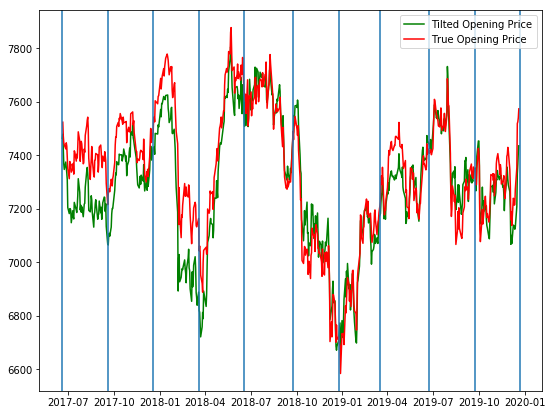

In [82]:
FTSEq317 = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Open'].values
FTSEq317date = FTSE[(FTSE['Date'] > quarterCutOffDates[0]) & (FTSE['Date'] < quarterCutOffDates[10])]['Date'].values

f = plt.figure(figsize=(9,7))
axs = f.add_subplot(111)
axs.plot(tiltedFTSE.index.values,tiltedFTSE['Open'].values,'g', label = 'Tilted Opening Price')
axs.plot(FTSEq317date,FTSEq317,'r', label = 'True Opening Price')
axs.legend()
for quarter in quarterCutOffDates:
    axs.axvline(x=quarter)
f.show()


Pearson CC between tilted FTSE and Pl price:  -0.49690238970637873
Pearson CC between real FTSE price and Pl price:  0.35506803242085316
Pearson CC between simulated (untilted) FTSE and Pl price:  0.19712841527467906

Tilt MSE 42067057.165264174 
Simulated FTSE MSE 33226522.349319074 
Percentage improvement -26.60686159990582 %

Percentage Change correlation - tilted and pl 0.0167921229588542
Percentage Change correlation - untilted and pl 0.11231818797891009


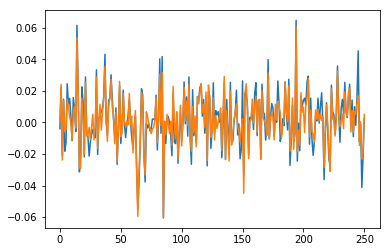

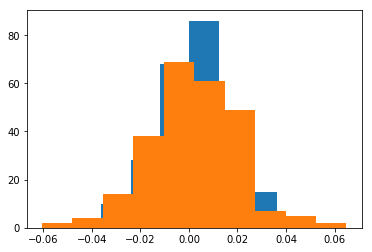

In [67]:
#Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
simulatedFTSE2019=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date()) & (simulatedFTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date())]
FTSE2019=FTSE[(FTSE['Date'] < datetime.strptime('Dec 21, 2019', '%b %d, %Y').date()) & (FTSE['Date'] > datetime.strptime('Dec 23, 2018', '%b %d, %Y').date())]

#Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
#

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE = pearsonr(tiltedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE[0])

#correlation between real FTSE and pl price
correlationFTSE = pearsonr(FTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between real FTSE price and Pl price: ',correlationFTSE[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE = pearsonr(simulatedFTSE2019['Open'].values,plPrice19['Price'].values)
print('Pearson CC between simulated (untilted) FTSE and Pl price: ',correlationSimFTSE[0])

#will only use simulated untilted FTSE price from now on

#Find mean squared error between pl price and tilted/simulated FTSE
mseTilt = mean_squared_error(plPrice19['Price'].values,tiltedFTSE2019['Open'].values)
mseSimu = mean_squared_error(plPrice19['Price'].values,simulatedFTSE2019['Open'].values)
print('\nTilt MSE',mseTilt,'\nSimulated FTSE MSE' ,mseSimu, '\nPercentage improvement',(1-mseTilt/mseSimu)*100,'%' )

#find daily percentage changes for tilted FTSE , untilted simulated and pl price
percentageChangeTilted = ((tiltedFTSE2019['Open'].shift(-1) / tiltedFTSE2019['Open']) - 1).reset_index()
percentageChangeSimuFTSE = ((simulatedFTSE2019['Open'].shift(-1) / simulatedFTSE2019['Open']) - 1).reset_index()
percentageChangePl = ((plPrice19['Price'].shift(-1) /  plPrice19['Price']) - 1).reset_index()

#find the difference in daily percentage change between pl price and both Tilted FTSE and simulated untilted FTSE
PCDiffTilt = (percentageChangePl['Price'][:-1] - percentageChangeTilted['Open'][:-1])
PCDiffSim = (percentageChangePl['Price'][:-1] - percentageChangeSimuFTSE['Open'][:-1])

#find corrleation between daily percentage changes for pl price and tilted FTSE
print('\nPercentage Change correlation - tilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeTilted['Open'][:-1])[0])
print('Percentage Change correlation - untilted and pl', pearsonr(percentageChangePl['Price'][:-1],percentageChangeSimuFTSE['Open'][:-1])[0])

#plot of the daily percentage change difference between [pl and tilted] and [pl and untilted] 
plt.figure(1)
plt.plot(PCDiffTilt.index.values, PCDiffTilt)
plt.plot(PCDiffSim.index.values, PCDiffSim)

#histogram of daily percentage change difference
plt.figure(2)
plt.hist(PCDiffSim)
plt.hist(PCDiffTilt)
plt.show()


# moving average stuff
#movingAveragePCPl = percentageChangePl.rolling(5, min_periods=1).mean()
#movingAveragePCTilt = percentageChangeTilted.rolling(5, min_periods=1).mean()
#print(pearsonr(simulatedFTSE2019['Open'].values,FTSE2019['Open'].values))
#print('MA correlation', pearsonr(movingAveragePCPl,movingAveragePCTilt))

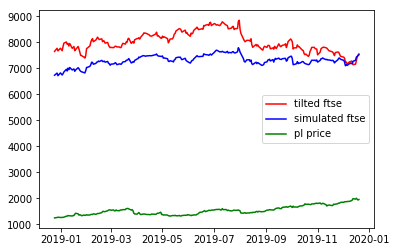

In [61]:
#plot of absolute tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].values, 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].values, 'g-' ,label = 'pl price')
plt.legend()
plt.show()

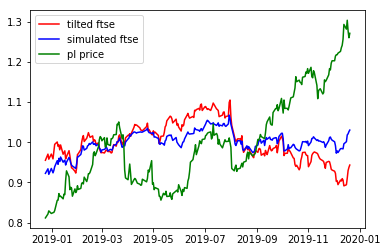

<Figure size 432x288 with 0 Axes>

In [62]:
#plot of normalised tilted, untilted and pl price values
plt.plot(tiltedFTSE2019.index.values,tiltedFTSE2019['Open'].divide(tiltedFTSE2019['Open'].mean()).values, 'r-' ,label = 'tilted ftse' )
plt.plot(simulatedFTSE2019['Date'].values,simulatedFTSE2019['Open'].divide(simulatedFTSE2019['Open'].mean()), 'b-' ,label = 'simulated ftse')
plt.plot(plPrice19['Date'].values,plPrice19['Price'].divide(plPrice19['Price'].mean()), 'g-' ,label = 'pl price')
plt.legend()
plt.show()
plt.savefig('groupTrad.png', bbox_inches='tight')

In [64]:
#Get only 2018 FTSE values for tilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
simulatedFTSE2018=simulatedFTSE[(simulatedFTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (simulatedFTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
FTSE2018=FTSE[(FTSE['Date'] < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (FTSE['Date'] > datetime.strptime('Dec 16, 2017', '%b %d, %Y'))]

#get pl price for 2018
plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

#--------using FTSE tilted using weights trained on 2019---------

#find correlation between tilted FTSE and palladium price
correlationTiltedFTSE2018 = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between tilted FTSE and Pl price: ',correlationTiltedFTSE2018[0])

#correlation between simulated FTSE and pl price
correlationSimFTSE2018 = pearsonr(simulatedFTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between simulated (untilted) FTSE price and Pl price: ',correlationSimFTSE2018[0])

#correlation between real FTSE and pl price
correlationFTSE2018 = pearsonr(FTSE2018['Open'].values,plPrice2018['Price'].values)
print('Pearson CC between real FTSE and Pl price: ',correlationFTSE2018[0])




Pearson CC between tilted FTSE and Pl price:  -0.246265188169709
Pearson CC between simulated (untilted) FTSE price and Pl price:  -0.5305275937035296
Pearson CC between real FTSE and Pl price:  -0.5472277825446668


In [24]:
#Modified Dartboard for my categories
dart_coef=[]
for i in range(1000):
    tiltWeights = pd.DataFrame(index = fullStockListDf['0'].values)
    minePd = np.random.uniform(-2,2,1)[0]
    mineOth =np.random.uniform(-2,2,1)[0]
    autoRel = np.random.uniform(-2,2,1)[0]
    autoCar = np.random.uniform(-2,2,1)[0]
    defenceInd = np.random.uniform(-2,2,1)[0]
    finSec =  np.random.uniform(-2,2,1)[0]
    jMat = np.random.uniform(-2,2,1)[0]
    noInt = np.random.uniform(-2,2,1)[0]
    catTilts = [minePd,mineOth,autoRel,autoCar
                ,defenceInd,finSec,jMat,noInt]
    tiltedFTSE = jackTilt(catTilts,tiltWeights)

    #Get only 2019 FTSE values for tilted FTSE, simulated untilted FTSE and real FTSE - starting from the beginning of Q1 19 (24/12/18) to Q4 (20/12/19)
    #tiltedFTSE2019 = tiltedFTSE[tiltedFTSE.index > datetime.strptime('Dec 23, 2018', '%b %d, %Y')]
    
    #Pl price for the same period is 'plPrice19' defined where individual stock correlations are found
    #
    tiltedFTSE2018 = tiltedFTSE[(tiltedFTSE.index > datetime.strptime('Dec 16, 2017', '%b %d, %Y')) & (tiltedFTSE.index < datetime.strptime('Dec 23, 2018', '%b %d, %Y'))]
    #get pl price for 2018
    plPrice2018 = plPrice[(plPrice.Date < datetime.strptime('Dec 23, 2018', '%b %d, %Y')) & (plPrice.Date > datetime.strptime('Dec 16, 2017','%b %d, %Y'))]

    #find correlation between tilted FTSE and palladium price
    correlationTiltedFTSE = pearsonr(tiltedFTSE2018['Open'].values,plPrice2018['Price'].values)
    
    # add correlation to sample list
    dart_coef.append(correlationTiltedFTSE[0])
print(dart_coef)

[-0.18945394989214787, -0.5447365677137309, -0.4476597936452062, -0.4529793160401014, -0.5639196119629225, nan, -0.4536255763841599, -0.4741254386171078, -0.5558523761375656, -0.03269643833106325, -0.41777398501006624, -0.8329523911010916, -0.7082031564776334, -0.4827855286892148, -0.48530098967313773, -0.48587019408628673, -0.4824609292874925, -0.8237216279121398, -0.25249132066255636, -0.30293365191137356, -0.42848550231446403, -0.5247302500081498, -0.40317516673092446, -0.5282381769748489, -0.4631108582561746, -0.36440108130346943, -0.4356090545158713, -0.5228075984973369, -0.4445182784398889, -0.40009708280634804, -0.5371911806911491, -0.49568699980731706, -0.544529967553979, -0.45880203148039156, -0.5128153736275697, -0.5295957144813543, -0.29218817472938563, -0.4843544597414456, -0.5136213922993335, -0.8439261879458039, -0.29822894156303537, -0.471635494612642, -0.5441117875626977, 0.06612351182179456, -0.43415987466641887, -0.49980285016711196, -0.46131821590193267, -0.419438411

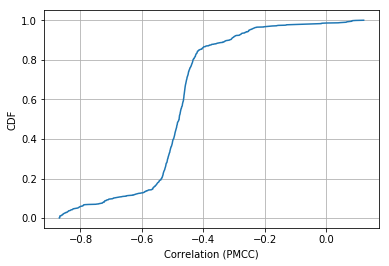

In [46]:
# generated from the above code, 2019 individual stocks
dart_coef_2019=[-0.17718560484635043, 0.07053701830767226, 0.21211043870220386, 0.18073829479605957, -0.03187650195004618, 0.252144207916097, -0.2803989579958393, -0.005441843322988974, -0.006588276662144724, 0.1485630778054982, -0.21489655806151434, 0.23557431478875315, 0.18218349343959475, 0.04703100066871671, 0.26465624237570706, -0.0914176295928836, -0.06767426311607277, 0.0150838815696062, -0.16820600963275012, 0.033015421345693595, 0.20503074218925915, 0.23231646763167277, 0.09050121168995003, 0.2550176584722416, 0.15333838539600184, 0.1320371860788921, 0.18169780860013196, 0.26500924237124385, 0.18690600841761013, -0.11903118395399395, 0.26469333585228627, -0.1695168966336714, 0.22105311888293055, -0.27719926854310517, 0.018251225683673027, -0.12243842862887082, 0.17265372206761603, -0.5052738483910407, -0.14645961187973838, -0.0515649183309521, 0.22583754136075435, 0.06447953186674324, 0.07136159114636578, -0.09129892011468702, -0.09945772319091672, 0.076289457449132, -0.16577708397345534, -0.025637316018020995, -0.2720464715973399, 0.01824720974535431, 0.2013899435730591, 0.22748979501291003, 0.24177789641348282, -0.148670929206247, -0.1536863173817202, -0.13573407159422643, 0.13826682077331817, 0.0547592321594261, 0.12351265120548428, -0.06283635228657714, 0.15649937345385204, 0.1501031761867247, 0.0961307830777109, 0.18692191948914944, -0.011608810005812141, -0.012493723560382142, 0.16017174007471058, 0.038506135895968616, 0.1991631551613983, 0.1495084512887933, 0.23834977577697344, -0.2862645617067669, -0.17706384915719217, 0.0020398723088428305, 0.1631826593996355, -0.22528132804523293, -0.03972121920502109, 0.2495320355544464, -0.14813358443439334, -0.11110889713869887, 0.014786858586675968, -0.04456283174356472, -0.3309893885295533, -0.04675127234216364, 0.11350873389963662, 0.25314691618456053, -0.12606070635887404, 0.0011740185986373252, 0.09660852138798999, -0.1612083169016187, 0.08925119646082051, 0.233125441072875, -0.10845152176059653, 0.20333354101552742, -0.2632085054497788, 0.17072960965128348, -0.2540312797821777, 0.24227162546109837, -0.15335539714282245, -0.10243307983510966, -0.2576731946420282, 0.19935639707185626, 0.26073138101252935, 0.13921209623987527, -0.018261659585906406, 0.26111007211734105, -0.07456543212563027, -0.1117809724840191, -0.2756609746961473, 0.05971135917784591, -0.0023035242797914447, -0.15877459281535147, -0.03918823709368483, 0.2184795067083773, 0.17961091916627872, 0.31121622106651325, -0.23420772263136666, -0.15124004089160242, -0.09336359776035885, 0.19415385637229976, 0.10019722566816074, 0.22196622102669317, -0.2023904798792685, -0.07484839701317775, -0.03738833477770255, 0.18351569287738537, 0.2464039803482283, -0.022932220370491894, 0.19785515232700174, 0.15532302085590197, -0.12428103348756094, 0.16396638240357891, 0.22010102912838925, 0.20177780708194984, -0.12020261036721663, 0.06982794305041419, -0.0878830090079872, 0.09718628899544215, -0.27447014031368966, 0.2078785981353592, -0.04992249423187079, 0.268389633930909, -0.11653090586313099, 0.22802493783306674, -0.03693570810585038, 0.01729961254475873, 0.008218834583126906, 0.1361593557114959, 0.15065823848886684, 0.027725133155884527, 0.27417383719111055, 0.2439415517297307, 0.20520653699042954, 0.1542759532494371, -0.06029959108647316, 0.2445399204696039, 0.16400272747505676, 0.07258738508902168, 0.050842170467197655, -0.09258689991861178, 0.08020742722575595, -0.023768879845796707, 0.22305332786329152, 0.2374455991634979, 0.2137986044816272, -0.17144496083894142, 0.2560308509598548, -0.2528826366615941, -0.025470013748841634, -0.2112085606437289, -0.0770045731689003, 0.2541245047422013, 0.019168938104990676, -0.04120197817001789, 0.005312448323497217, -0.030948282869215804, 0.24520393788458955, -0.10547244485540207, 0.009717602577084329, 0.24761245884917596, 0.2583717780417567, -0.25433310030290074, 0.14754841310300845, -0.06175951453731972, -0.04323814489141186, 0.09582987910625805, 0.21501546119193068, 0.07513051491851064, 0.12353720397963579, 0.27350609813088717, 0.25536299587576067, -0.08506630064597161, 0.25423261928375435, -0.006097141491036958, -0.05322336004648462, 0.19034534248139726, -0.3652796649706316, -0.2310701696020248, 0.2005458764540335, 0.08616642143312177, 0.013657877045478394, 0.2581405058390794, 0.1312488259084829, -0.4004255902709593, -0.022108844377988407, 0.24579613775355516, 0.2429604875745614, -0.28323093780438185, -0.23217373663239305, 0.26386806067436636, 0.03273833764388633, 0.11018444611813676, 0.2659168800996125, 0.24592106568420288, -0.2368341570107361, -0.09137037182791513, -0.11295668608822636, -0.03311520731007359, 0.0026928236937281236, 0.26402217756210467, -0.01114639817450283, 0.07797604789035747, 0.2248577749568074, -0.058738903802424726, -0.0685565055730419, -0.23484957004741078, 0.19171677597388126, -0.08498866277719601, 0.09422578978911482, 0.26268062775182216, 0.2348065211775287, 0.31118106588701044, -0.14302238232607697, -0.28067958344927046, -0.16790111701086827, -0.17664542877433967, 0.21003256812896248, -0.07236291486590465, -0.34367332653349353, -0.11416347182790593, 0.24369882863162615, -0.0013158124241468914, 0.08921059007512763, -0.004879234277771832, 0.09615392119217994, 0.038932107837487934, 0.016027875143234397, -0.13450870296580458, 0.25533711040862556, 0.3241745868969154, 0.054754284587173976, -0.2231353011089064, 0.04139600367100692, 0.20933667887397606, -0.2698114334489674, -0.1869459011358735, -0.10786595335588346, 0.25447335197820353, 0.24711195069866093, 0.029342346536007164, 0.26245706776296107, 0.31122490360164645, -0.21805719798703607, 0.03692074908427645, 0.02149836541603191, 0.22942817596909748, 0.22561115592064215, 0.23243892055441276, -0.22818352132843886, -0.0209984558522401, 0.21869625271944174, 0.2386649714022902, 0.27456655546510855, 0.03772475607020622, 0.24319550441986676, -0.17748632767959868, 0.21453238076073408, 0.11098358341365593, 0.18722919356300058, 0.0032848492393209913, -0.030801838108580216, 0.149748064726699, 0.302828723628039, 0.010052978813546325, 0.01046804453116422, -0.18208624218699943, -0.1903701992459624, -0.13317505300340834, 0.1184776310576943, 0.2203013932040569, 0.23355765175873427, -0.031599248911406475, 0.2553647903814948, 0.2537293393888967, 0.20317478461665067, 0.21082555133214806, 0.24577249219394073, -0.26110125886351454, -0.19245848885878242, 0.25405830009892844, 0.2524249614034464, 0.018492711918283028, 0.08115383338322928, 0.23903790829319904, -0.13222114634111198, -0.2803631158736547, 0.1755876720675844, 0.18309702444625311, 0.23202921179447059, 0.17404736663540052, 0.2519197259339015, -0.17336689780964698, 0.16889743566242624, -0.22926655676825658, 0.25853163799026785, 0.028235009413374097, 0.11644578256589816, 0.2448637447265881, 0.16513304074188695, -0.19101128345576546, -0.11239203018815824, 0.126587889218561, 0.1300487107458068, -0.0015360525234891912, 0.027108548373713837, 0.26784881404206545, -0.03865323076741992, -0.01642839175083092, -0.2606760332288739, -0.07374368716052784, 0.17817754044231476, -0.1189105496181232, -0.25957482821394623, -0.00394617907430184, -0.20909094715134222, -0.6759275076798822, -0.08900051240101411, 0.22851738792498147, -0.1002644638322238, 0.23367141604009176, 0.24869916788747579, -0.015979101301320534, 0.2658727619967964, -0.1083275869925665, 0.013408818861730017, 0.2298610818377823, -0.02074784772841961, -0.24066577069033368, 0.20221019625326642, -0.2561143375930475, -0.27137220981925836, 0.0699522245596672, 0.09222468179971946, 0.15114392868397725, -0.017357942399320536, 0.20465500307990117, 0.18549058873375904, 0.06377457527252091, 0.022010657073275732, -0.01733567632854419, -0.10641596445824428, 0.30155133076297674, 0.0680663917552906, -0.22259101937715822, -0.032406247286261215, 0.2647767236695667, 0.18891114870950065, 0.1980361615711348, 0.19414189384097214, -0.2651883182536601, 0.15751503195928787, 0.1876058097737657, -0.17869706809096933, -0.2554515540833255, -0.280022866480535, -0.12268167782372351, 0.10896110199151361, 0.1775774938542421, 0.1491423520118493, 0.03305630087631231, 0.2320839465985798, -0.14428442599409966, 0.02920924594096394, -0.2642966139724915, 0.03130584552371355, 0.0424152477292726, -0.3446819234350208, -0.0238403488213848, 0.24725648884851775, 0.2651035713402855, 0.053676736878744157, -0.07182051823805652, 0.2510647241586434, -0.19225113839448446, 0.16479099543548612, 0.08740115482847527, 0.0297609023877882, 0.2703836885874359, 0.11337947800613798, 0.022695232795816672, 0.21958572831893497, -0.20317303942946993, 0.23509916872284384, 0.19072634952232892, 0.2597239689404056, 0.02862258274922629, 0.15620752774911, 0.12816318300674015, -0.24469922291020008, 0.13839925475435175, -0.17475466300527676, -0.1430549761433231, 0.1171060428040418, 0.18255442382468767, 0.2351826821782962, 0.14223103573710366, 0.014856922862075277, 0.2224283742425098, 0.1929493303221843, 0.26097248892551106, 0.31036755966384144, -0.05754207116962382, 0.03611184337470002, 0.044849761035858214, 0.3374374829400931, 0.01984520961195126, -0.28439327450273366, 0.010843328010971228, -0.16941732912355348, 0.019674943052128146, 0.02954666406266791, 0.13992140368654496, 0.08506191221947684, 0.26054957673710333, -0.1858953407052629, 0.13739031396208057, 0.20777558342849314, 0.1790721128011735, -0.15393705261060261, 0.1856372876717093, 0.24372561819877506, 0.2279385409540805, -0.0292511473332949, -0.1897780791294109, -0.1015117427146749, 0.015057639573604405, 0.19835084499549602, 0.004246385800176474, 0.23139734060667147, 0.2510069228237539, -0.029205589733231438, 0.25709434669954745, -0.21919508259217751, 0.19625518703080408, -0.09236373570363768, 0.24267481625279883, -0.28935934249438855, -0.24748903121668403, -0.14394442891067472, -0.05340033066984023, -0.14924955782284433, 0.132313789700992, -0.14259305917769394, -0.007099633876563305, -0.18793991225046924, 0.31121883185920124, 0.24008152046045786, 0.2078938211811242, 0.0006843145562943777, 0.247313326457413, 0.2694168678471344, -0.05314030022575387, 0.02161482103429622, -0.005785694630951331, -0.2701080431238502, 0.09795427989548422, 0.30274301797934217, 0.2417387021955757, 0.29510461672465216, -0.24264266342194987, -0.026553245794885216, 0.26640504360772327, 0.23516674670557078, 0.2013808745405797, -0.08875915380340227, 0.20721636353851391, -0.22935302511920921, -0.026685989990962257, 0.1807506740145508, 0.1484059196142257, 0.22806111138747115, 0.2340424104454415, -0.08219977829796676, 0.2272155391973579, 0.1678532503447692, 0.04288248670168825, 0.12557043224400577, 0.06628067600184516, 0.2370961006574697, -0.004981518490270618, 0.049365228308987055, 0.04950888894787723, 0.20568001723827775, 0.07164622587523808, -0.2754099799512991, -0.014959702916971936, 0.12246294071045115, 0.09675482309903159, 0.23063762905805224, 0.24487607602767814, 0.2653679322432307, 0.26537099837936895, -0.08287005827915137, 0.17978173729830682, 0.20249994702441593, -0.09076424630434905, -0.11459894530378768, -0.02295488475258994, 0.19833613240305786, -0.24417758228497283, 0.06331526656486458, -0.07316615899786275, -0.05857334255842676, -0.004038218676864299, 0.11738694857648316, -0.5616629438279283, 0.13798260935400702, -0.07732664739410829, 0.17354752339828272, -0.19703318643685844, -0.05416409848904373, -0.2835862284035068, -0.09575001006681745, 0.17697285212042063, -0.26099743754546667, -0.05232502870431171, 0.26937236826028826, 0.25081148524284436, 0.12435424615024869, -0.014379721583803918, -0.07563002798936885, 0.34130070132481943, -0.08066114132965325, 0.30271724792541227, 0.009392079103753684, -0.2253270456947407, 0.2418513913272859, -0.23917325432194436, 0.016383716654182486, -0.020189682955470304, 0.17149960272145276, 0.10768717382214395, 0.2389431893005997, -0.011598972385567707, 0.12923254685207022, -0.2645218644281951, 0.0017250696885464853, -0.2520042956782926, -0.03479343213133076, 0.12017261778211905, 0.25172640087900483, -0.06998729368781142, 0.2398321901104904, 0.2157342022033287, -0.26947403757818805, 0.1813425667564852, 0.24515030630527834, -0.24571881444017182, -0.14236696650276062, -0.05586670762772432, 0.18247440263855474, 0.22844305952808622, 0.0796555652342236, 0.23591094461905876, -0.03920279789126643, 0.16567831726257917, -0.3786580321592036, 0.07846757427986938, -0.13456790474372504, 0.03692100498460038, -0.3975367350602984, 0.12343350262277672, -0.11972198916034126, -0.1916066190631049, -0.011027915693853599, -0.04858070872893954, -0.09660228218234494, -0.05544005791382563, 0.1811137832932673, -0.33591219039741027, 0.0031995586269289366, 0.1860418323282962, -0.18461771785047026, 0.03963520405045216, -0.12783780541494266, 0.16793096523877712, 0.004284981408718006, 0.023728660209297762, -0.04512624284070459, 0.26745602486210307, 0.08522759376683167, 0.3027187384435569, -0.2620482953342936, -0.26267531939337885, 0.18856347675834476, 0.16358250671498165, 0.04256107020278956, 0.22256015197887424, 0.26542651171890724, 0.26039143704029966, 0.25021731879055087, 0.1823482667853214, 0.21021764203425544, 0.2065168142948635, 0.2244166433127482, 0.19292468022339251, 0.30419782869256645, 0.055729365801046024, -0.2992539220737393, -0.1952764911693314, -0.03215213769092189, 0.2419327717162138, 0.013319298324973914, -0.1185926835337666, 0.03166487674407364, 0.057083859760681296, -0.003512800269259883, 0.31925312434548037, -0.04200646605711345, 0.2664965450420005, -0.24571337017079756, 0.249736561007735, -0.03870211324841315, -0.2164381102792293, 0.24030918253157493, 0.22367679098666532, 0.2527899085821623, -0.3370512364845343, 0.0542040941301752, 0.012817649396718735, 0.22720436347672096, 0.18913360277822447, -0.2636925061813369, 0.24736944746732334, -0.17547834498410395, 0.27476396901762395, 0.0424597380202331, 0.25000603745791905, -0.050469107322784805, 0.13995403749232144, -0.0107858483063107, 0.21554394734118043, -0.018605011888048185, 0.2522292924166687, -0.17333431801884117, 0.22784692320335198, 0.15449941847369905, 0.20530870145720245, -0.0591851882235592, -0.04438137496679137, 0.2661909495444324, -0.06470017923959337, -0.41888804195186047, 0.20040183456320335, 0.15371553633472781, 0.24888818264284626, 0.09780796345633681, 0.19434614783879403, 0.10815559105158717, 0.20930362797713734, -0.337748676937218, 0.20017743035870753, 0.17812902540247597, 0.20542269700693913, 0.2562181249781572, -0.17916778904034247, 0.23280245500852326, -0.01903531120473358, -0.3033963696047368, -0.042705014569513186, -0.2056721851434937, 0.06097159838928852, -0.08040754500964085, -0.6994263613016108, 0.21528671722225562, -0.3596581068108951, -0.010132283179051283, -0.2662769212577688, 0.2393645143637892, -0.19315175898934275, -0.033442318231105696, 0.1474931914493091, 0.10739369326498792, 0.15043431171286642, -0.23572299394675708, 0.13906383870948308, -0.1994002983417096, -0.14470067128744318, -0.021690870006903486, 0.17272230552921897, 0.18609390607745435, 0.20961233306901397, 0.02292079139110167, -0.1475924794020683, 0.2210702942294288, 0.197670909469586, -0.26351962543968677, 0.22445150332557745, 0.20433700973321645, 0.1093085925033341, 0.25502295295565425, 0.2467662893274794, 0.22005977016537911, 0.22840170270981355, -0.17566727065500842, 0.017229298643070202, 0.036949516106229874, 0.19912101701972906, 0.19612822651644196, -0.19260620189343672, 0.12484930036798253, 0.032028716601061526, 0.1707248324711655, -0.038206061646131946, -0.11212978409876849, -0.09291541405010047, 0.20130004677167823, 0.21811840844756342, 0.19437666738786308, 0.22391552358623662, -0.0093432268382929, 0.18553030894470723, 0.12356912120363622, 0.24378359824604057, 0.16296684915779025, -0.0754334895733638, 0.1848144540451044, 0.060672495445050975, -0.3958625427133675, 0.23816708120448413, 0.21798875715465654, 0.186063682081331, 0.1636136869743292, -0.1742294123170463, 0.215850032493123, 0.16761342538019564, -0.04630597324140091, 0.2577408203866171, -0.1906086394042724, 0.16110200669121771, -0.029198837927374877, 0.015786281446069153, 0.25304731543943093, -0.17474455868893937, 0.21650898983136282, -0.19497232570852752, 0.17458009247900386, 0.23831391613826508, 0.23112436068308306, 0.2038129030275757, -0.13742765133645676, -0.11443004485622908, 0.21313224179185403, 0.04202288460953136, -0.17676957335076596, 0.22028453172767717, 0.1319822701420542, 0.22946407596789983, 0.25813862145932526, -0.2721803283284541, 0.18453142300141698, -0.2263795300306307, 0.172700969326585, -0.04745612311108216, 0.25991747716231794, 0.21295582077807138, -0.08559878457219593, -0.05438127862844025, 0.015456623470294846, -0.19546913712459008, -0.02748346917776809, 0.161697296418513, 0.17594053769830914, 0.3379819345837907, -0.1092678415592133, -0.13328250399410915, -0.12674055708904122, -0.09327519868932807, 0.03663273010890914, 0.20827882888280308, -0.04911061968158116, 0.0590323042939376, 0.20509241543713827, -0.047943033490966236, -0.27163920129873526, 0.09364229771223319, -0.0019375506840033489, -0.23798185608220995, 0.2259535000886729, 0.23769421783420505, 0.21364658422750446, 0.23536800063883634, 0.2574261337362408, -0.12968856596066827, 0.06596299206890129, 0.19946358031677008, 0.08969072665892962, -0.15539266369909704, 0.22688465704924646, -0.20221614391684842, 0.08085980602227777, 0.05409719262188499, 0.02792103791966758, 0.06943944193991076, 0.07707018426508651, -0.06458812663066968, 0.16764639231268835, -0.2786582699164751, 0.26826832771290343, -0.25822243192597794, 0.3500854175514024, -0.06495588676833108, -0.04094309194802834, 0.2626715420681348, 0.23151108322161787, 0.241731194940717, 0.16613843692068855, -0.13142755451851212, 0.22087346472103186, 0.26409043112808867, 0.238324255241603, 0.10423605204121182, -0.22467720684157788, 0.022513285533233188, -0.11402239327180375, -0.13472473795502582, -0.14077825271265623, 0.2371512778616069, 0.17446139948508407, -0.07234314588630258, 0.030920267094043732, 0.20384586952916836, 0.24969777691995443, 0.296081847060402, 0.15441828054511086, 0.09630871200023801, -0.026832531437662163, 0.1777186485204939, -0.1180737206078861, 0.21292229019662337, 0.07208078684981672, 0.24610614132080508, 0.10679147449623587, -0.0836410439051688, -0.012384376123860091, 0.1865975024646516, 0.1593971671311119, -0.009274254750631233, -0.028052772443795525, 0.14227815322042395, -0.30196015278869853, -0.2557469677959815, 0.18684058806853726, 0.25793873615058327, 0.16351655687126027, 0.21164733680511058, -0.2617445367008053, 0.22811407322297708, -0.15937859524110248, -0.25578677414899825, 0.19069652142896276, -0.17355356162898095, 0.006545718428076384, -0.20308555460397731, -0.08396894051168681, -0.24467124417805364, -0.2779940148267119, 0.23230284811679602, -0.25746882131146615, 0.3027039542770973, 0.05357525265276581, 0.07818378955052241, -0.17529414853256411, -0.14783214761412036, 0.09960806025473196, -0.1930748888634804, -0.05672928419778403, 0.21886104654445931, 0.12617930282829473, -0.05192993165023395, 0.23544165219447097, 0.26382385716676093, 0.2532928915762536, -0.0037454950643698646, -0.6466348623643956, 0.10507508617235277, 0.24840798167289854, 0.02285607888636844, 0.2448709621012699, -0.05670769508588497, 0.16461377984537284, 0.04151134124692658, -0.25060905320481086, 0.11646622309449092, 0.18915396059706607, -0.2474888608543523, 0.25017486745330747, 0.20115663477139267, 0.19686190207696938, 0.09606773477416741, -0.09735410900416074, 0.26634265211940733, -0.042533651856236115, 0.11304844816456701, 0.24539761561694753, 0.2705502763242744, 0.15956485184514296, 0.20040427235456681, -0.17805711069251354, 0.13856429993517935, 0.02758031070523329, 0.006279758012516012, -0.012916395908067963, -0.26782551289070206, -0.0067424080941852396, -0.1917763959545057, 0.217003504456232, -0.1092325594520316, 0.24007291834788883, 0.26795413314731104, -0.01840334304689792, 0.17094468269986457, -0.22408003403748666, -0.13454942123378302, -0.1779905867200056, 0.18790505454434533, -0.28162596262208894, 0.3285535765404291, 0.05129098239074358, -0.032326615155506694, -0.1628615294467831, 0.1816296148073261, 0.21976691453285685, -0.02375574627956328, 0.2136908778878746, 0.051066048512837116, -0.16529262422026916, 0.20422227088199957, -0.1243823580419248, 0.20501400193193986, -0.07823884351648695, 0.2103188593102074, -0.1863462832976496, 0.1925748002591327, -0.24552872711176615, 0.1469318026312251, 0.17011462789449572, 0.16589645276694623, -0.24960181615245589, 0.2292676040109862, 0.1718833360984282, 0.15482452458324478, 0.1895647436495087, 0.14547229892719016, 0.24074449845957233, 0.24296416721277767, -0.13317535688842397, 0.19973044314802094, -0.10122513517089017, -0.29131017475631055, 0.2852606612701517, -0.06517395064587428, -0.2030541680761182, 0.1784807625254305, 0.3303125313298447, 0.26311043972705894, 0.06371066000609228, 0.19697714707952477, 0.24909641559596493, -0.17928083917347915, -0.06561028486934138, 0.09550749437440763, 0.002160989344689483, 0.051446603917267394, -0.12055918034864932, 0.10590026004054051, 0.2168583969241234, 0.07780247920517794, 0.25222716609359624, -0.08606185948602184, 0.2310249542912761, -0.08839364758079891, 0.2464979532648287, -0.02916300242178539, 0.047056534144915535, 0.06643041454770511, 0.25634865482164315, -0.20783479406260194, -0.046688650623849456, -0.27454171630818575]
nan =  -0.5639196119629225+-0.4529793160401014/2
dart_coef_2018=[-0.18945394989214787, -0.5447365677137309, -0.4476597936452062, -0.4529793160401014, -0.5639196119629225, nan, -0.4536255763841599, -0.4741254386171078, -0.5558523761375656, -0.03269643833106325, -0.41777398501006624, -0.8329523911010916, -0.7082031564776334, -0.4827855286892148, -0.48530098967313773, -0.48587019408628673, -0.4824609292874925, -0.8237216279121398, -0.25249132066255636, -0.30293365191137356, -0.42848550231446403, -0.5247302500081498, -0.40317516673092446, -0.5282381769748489, -0.4631108582561746, -0.36440108130346943, -0.4356090545158713, -0.5228075984973369, -0.4445182784398889, -0.40009708280634804, -0.5371911806911491, -0.49568699980731706, -0.544529967553979, -0.45880203148039156, -0.5128153736275697, -0.5295957144813543, -0.29218817472938563, -0.4843544597414456, -0.5136213922993335, -0.8439261879458039, -0.29822894156303537, -0.471635494612642, -0.5441117875626977, 0.06612351182179456, -0.43415987466641887, -0.49980285016711196, -0.46131821590193267, -0.4194384113436567, -0.6355834162710797, -0.5094867272147703, -0.5536230053943325, -0.5069818530477881, -0.7155594500154648, -0.7894219972280117, 0.09710767655249426, -0.8627827547984979, -0.2515103802538945, -0.4629364040587072, -0.39107804979680666, -0.4532791054133886, -0.5346566804258812, -0.7285635641761532, -0.4333573203681152, -0.6447675550350369, -0.4783782493012076, -0.305105464569674, -0.28286807544007964, -0.47541992763223734, -0.44585382365376397, -0.23793625300941426, -0.46239835304588717, -0.46796459429126386, -0.47854353874877226, -0.4960761394840197, -0.48623335402539436, -0.4568751462919912, -0.499206441511713, -0.32982487264040095, -0.514228764988032, -0.4382677603117358, -0.48615486589986734, -0.4868141393619375, -0.5049076980373408, -0.2455101121062373, -0.4476183201718317, -0.1949666204775624, -0.42344676033996187, -0.735250952652524, -0.48357613679557315, -0.4751209218157983, -0.5608742969790483, -0.4807557583649838, -0.5296981237729425, -0.47084022433094874, -0.8618516345331807, -0.45091029823334344, -0.15547548647706239, -0.802654556868448, -0.29974384744452426, -0.8129883444284292, -0.5213297283025434, -0.46426525065614366, -0.27319665641827506, -0.46665032665393036, -0.4987349211878829, -0.4085926160228867, -0.4596465233919718, -0.45897560337639365, -0.44650719449319554, -0.2759625787778064, -0.509814129319169, -0.5918079461589757, -0.2959895798699566, -0.42614553761245993, -0.4241601659878211, -0.5025139904196979, -0.8672898832201162, -0.4834193404311836, -0.4919186274588694, -0.48614177029305006, -0.531685003523395, -0.6957336769933303, -0.5315921438132654, -0.45014773349911563, -0.46260979335188246, -0.42900628771461746, -0.5259721754844346, -0.2635426189631351, -0.4716545464567773, -0.40063234585957214, -0.5235519479974, 0.07368499063825683, -0.4892797099238541, -0.4627881377067711, -0.5900213493863525, -0.7074069361160903, -0.5428317319818335, -0.48814780319045986, -0.5206077217626004, -0.5144428500182799, -0.47755148945869447, -0.5306081683570352, -0.45972155539527254, -0.5000365458806572, -0.5312940524780043, -0.484066762193267, -0.48476794934602363, -0.4389616467691517, -0.8441317738490913, -0.5230449742630834, -0.4702511576498129, -0.5303168158640663, -0.48843358986504903, -0.43853045405468355, -0.4446483146328964, -0.517061882338572, -0.4576379516069774, -0.16094263901307052, -0.4479765302474627, -0.5579232903692213, -0.8578035359404408, -0.45504733423083427, -0.45807014854109257, -0.43797811768624517, -0.40226085470090517, -0.6287304880786532, -0.47699366164546453, -0.3057224082520952, -0.48017167998558336, -0.46052346283844575, -0.30712001164203084, -0.8244550994551136, -0.792449715074243, -0.43181194328513967, -0.5478492767665185, -0.4682396530104357, -0.31326793966467054, -0.47834048499166437, -0.5214500678136696, -0.3976152081321915, -0.4873041924488962, -0.4337833744952083, -0.5347020597889478, -0.5324245074345287, -0.5143319218735587, -0.44307759846742845, -0.4518923543572824, -0.523300120413369, -0.785847554974231, -0.5085417878345841, 0.07792716573454554, -0.4405040957152892, -0.4368041889318879, -0.4214343375686463, -0.46277524156119104, -0.4779316272776662, -0.508449131488208, -0.4898450668812176, -0.46824743801700053, -0.4478494043955108, -0.4562267765460378, -0.49509299245348004, -0.49925065294822224, -0.8312657236938447, -0.4402867660929842, -0.12863969544181433, -0.4442198926758817, -0.8051769118841362, -0.4270596273890346, -0.5217812470715032, -0.5130953552005189, -0.4647618303685454, -0.4947831391332131, -0.7230321437912355, -0.47743011048901246, -0.5306919504370748, -0.46313876437621465, -0.5152089225919659, -0.8576869504909107, -0.5633298462284082, -0.48642919334145435, -0.3469214462160129, -0.30902854029243904, -0.5540700009343139, -0.6766803583304678, -0.45743745688065135, -0.45892427466478536, -0.011785795174088825, -0.4192910151396051, -0.8195993467043718, -0.48451426855434393, -0.5247310722018254, -0.20282886074016726, -0.12929163496302842, -0.47794817042576754, -0.6227584174858736, -0.43855723642956573, -0.45930568010689293, -0.4334207651228241, -0.5623126097741142, -0.41936163136673377, 0.0019616241472233138, -0.4341628965935343, -0.46573054981873585, -0.461903496084859, -0.49802784770153213, -0.27478858399949974, -0.5169684699977467, -0.7198217108591306, -0.5369263214349902, -0.473266665180402, -0.33581344328590224, -0.5248612423726431, -0.39041670621810715, -0.5930575591903259, -0.2020619710200877, -0.09123485507104982, -0.44833752859483605, -0.46034066660890866, -0.2756330469847231, -0.4737378977107652, -0.5911539802686094, -0.5013935862140292, -0.46410907117239913, -0.502940611857629, -0.24768281337675857, nan, -0.5282469892193529, -0.49137949883350146, -0.41914652671167674, -0.8590064211893731, -0.5322979091548143, -0.4923332018101808, -0.7740776189461238, -0.46104553959661887, -0.467331834102039, -0.5124439084672858, -0.604360424169693, -0.8034102952079298, -0.49250128047516184, -0.23999400786961242, -0.8556291732358182, -0.6123851187939641, -0.3003975418335822, -0.5298518605599197, -0.7989881191370689, -0.5118131042605186, -0.5435945934454188, -0.5020318131549529, -0.4627384005042877, -0.5158053319646463, -0.46109790178347587, -0.45930560165474793, -0.499694888209947, -0.35742670528400944, -0.5022711790253407, -0.4647950538452271, -0.5434893712205577, -0.5174509945041847, -0.2631452219234455, -0.5307111781324436, -0.4531311532072177, -0.46045285809961345, -0.7153093657084482, -0.4519103948508931, -0.4774778188539615, -0.40180282046657845, -0.45826599578453253, -0.29547597814713583, -0.4565692376918558, -0.4705800425739672, 0.08451863199826039, -0.392565529376743, -0.456638393472144, -0.4557642451187705, -0.5175285404763807, -0.48927923116927863, -0.493253132424875, -0.8334912271913106, -0.4609016747844402, -0.8548267667254116, -0.5182666064163697, -0.50296408231421, -0.5152164455895948, -0.8385119965675083, -0.47172170460037166, -0.4948732882943609, -0.4199687057451943, -0.5134500032365286, -0.4884698244758591, -0.41519302960114246, -0.5036514383149089, -0.5057326347105594, -0.2699388733127471, -0.42488264126280595, -0.36564788552038396, -0.6495524553205346, -0.4734934457160364, -0.6945837184813458, -0.46803135205672025, -0.45196595916775323, -0.4703351098023448, -0.5027286125303272, -0.4680652971070485, -0.5549862496910812, -0.4947774888302794, -0.49979462397830055, -0.49740558792872147, -0.6105826524811684, -0.5966610014851966, -0.5182459223498879, -0.8344048348434772, -0.5145067370616822, -0.45798625469164395, -0.2499869231453437, -0.49908683123319203, -0.5004100258537127, -0.4666733576868367, -0.3061172635262629, -0.45696721863710105, -0.2645116560759831, -0.44815261959710273, -0.5533269213076005, -0.4500100200137023, -0.42521775949102153, -0.4559090232930227, -0.50831586046495, -0.47860248962058405, -0.49505924775793914, -0.8674188141583598, -0.5315954094366334, -0.443699231719045, -0.4674813508259523, -0.4808202855292756, -0.4928871053310696, -0.5280057963948873, -0.23186457442507313, -0.5018588225482039, -0.4529718710263243, -0.46193242637024606, -0.4786705417732376, -0.5248519575660666, -0.4596792813329518, -0.43796747336426006, -0.7282838632422614, -0.5259221404050911, -0.5671115806599737, -0.5220601666769585, -0.4398966514567815, -0.46623307763849314, -0.6866447241093773, 0.08575602870123787, -0.43200421776460896, -0.46143896415754937, -0.5491670456950963, -0.5251004945486917, -0.49902020284275544, -0.42759637895428654, -0.8503942884504663, -0.37254850753914903, -0.5173227753483389, -0.4593986118243716, -0.4865314919946328, -0.7916904128360072, -0.4958232150916678, -0.474263046461102, -0.4232932650301846, -0.856747962908397, -0.6933373575866092, -0.380569743886313, -0.4886580881086024, -0.4776615515712568, -0.4606401918673422, -0.4805460164824654, -0.5503281682205186, -0.4564639123291083, -0.5579189601592193, -0.4342419962530736, -0.41459376768497797, -0.4577565453997061, -0.8135005500222683, -0.43306087739040433, -0.46070965575020945, -0.22639668525876952, -0.5007062952092707, -0.47472197299322644, -0.8566253514737849, -0.2762769116100263, -0.42528665665301796, -0.5082298684734803, -0.47282957853702146, -0.44918017462773935, -0.2641924706480659, -0.6509837068287425, -0.3754893323778532, -0.7984094744506958, -0.4490580641084819, -0.5129299683998154, -0.5280003799474638, -0.6719180533490859, -0.4504205530421276, -0.45494518828814445, -0.45977624821147905, -0.472612510048842, -0.43694407498381327, -0.52210839018037, -0.46632046338346417, -0.6594295208488836, -0.5512421554529555, -0.46643872396866476, -0.4434038099780485, -0.2781353112746035, -0.5494650273156335, -0.015380786770935831, -0.3983485789724487, -0.5412880878504882, -0.44972696038936666, -0.5120386704922582, -0.3357771114542406, -0.4842810369768771, -0.858129281079672, -0.4865130246207127, -0.48912052070577927, -0.7214940861622977, -0.5087237205597024, -0.6222905690969904, -0.4439497183573869, -0.5207569319991385, -0.41883763166150184, -0.7265028120978431, -0.28062237219679237, -0.8428837483769628, -0.33114722134090296, -0.5260702082650668, -0.46067025035281756, -0.4611178020331688, -0.5007266207299211, -0.5076633167278372, -0.44680472455664283, -0.45949872558260424, -0.5084260458934161, -0.42564394231454283, -0.2359830265572712, -0.6257927080323399, -0.529595763142268, -0.5075299812693259, -0.7465490271720296, -0.5127354825266125, nan, -0.5221823956546966, -0.5169240197514567, -0.7936520325311928, -0.4754976763049926, -0.5239899118758147, -0.5373230185623606, -0.41591000608934553, -0.8674340600268972, -0.5266918428666334, -0.44882390613921824, -0.8255103338552536, -0.566701981408293, -0.2332256958274526, -0.5070206473079673, -0.46953950256539395, -0.45305078326823955, -0.5381572117140574, -0.25132436777701733, -0.6662671951226076, -0.46645633611118636, -0.45938915566739674, -0.46447126967890445, -0.4905167843274036, -0.491918812369171, -0.31717356475524416, -0.5516693138485419, -0.45424467467304286, -0.45416492796437763, -0.40376350141346723, -0.5011406629664368, -0.48486239656278507, -0.47598033601847667, -0.721306007462427, -0.5180050262575151, -0.5225408101142127, -0.8673339246690767, -0.8673359895752762, -0.5113366971363379, -0.47825243577461957, -0.4641440756690089, -0.0696007723043272, -0.4922591633202628, -0.5800722368946101, -0.4916213312251257, -0.5351891491753981, -0.5038376489614556, -0.5170782658807914, -0.5600823385339834, -0.839658898294395, -0.453489081922095, -0.4902110735061329, -0.5299299537178799, -0.4295268117071811, -0.4982405149711243, -0.4703503828070973, -0.7091824161901532, -0.45144518273060236, -0.4626825746104084, -0.48538336682699224, -0.5168368784240689, -0.5091278496084732, -0.43700107855333187, -0.5118923816894334, -0.8530192825142908, -0.49115445438193694, -0.5333530665960277, -0.4578369547523647, -0.3501101947109521, -0.5286199091838161, -0.42415614455565415, -0.4460696193436939, -0.4867451399621972, -0.4185806022224402, -0.8488576708025419, -0.48177380580351853, -0.46579411064304377, -0.5631594763648666, -0.4288577513227979, -0.5466024768032484, -0.4598973792408694, -0.48874841685845394, -0.5335678498830893, -0.43167040034209675, -0.5911604562768832, -0.4461078814598517, -0.5070874096733633, -0.46136697596230586, -0.5789626674947295, -0.2536297495788397, -0.6783799317612361, -0.4246231478290865, -0.34366396621190154, -0.5276639278061765, -0.4883992661238093, -0.5322870730125947, -0.4748339226444062, -0.3119534523976801, -0.7135414207322394, -0.7144717601115886, -0.5851518825050621, -0.7317379208714013, -0.4361577553497205, -0.5346793629390223, -0.4799083193302366, -0.5016877731059624, -0.47184581758022426, -0.46314424910878244, -0.40397664227482444, -0.32537087405462184, -0.45674704664071997, -0.2254900549491473, -0.43681844754693167, -0.8072322936360093, -0.5185663125752296, -0.4753527809794758, -0.43337788752216666, -0.4555285350527533, -0.44089934909405704, -0.48020103745356213, -0.015235866493561394, -0.4927658470057417, -0.8063991831637889, -0.5420596236554122, -0.7216104600302966, -0.5166967585132217, -0.44629287436977, -0.2798750809748427, -0.4571369857806282, -0.4932083094971342, -0.46170418782865097, -0.4326827139940956, -0.5061601338229405, -0.4486705791293742, -0.4802396255383631, 0.04634918619381205, -0.46275382037802565, -0.7212194852072371, -0.46304936465424595, -0.4893718699795072, -0.4409486091401334, -0.3296596232356625, -0.5631237192225655, -0.24290879294864579, 0.0669338950797082, -0.45865215190789965, -0.47704633407579017, -0.8673004523473957, 0.08446815389474016, -0.23061607805214562, 0.040018994384110815, -0.4951485623455658, -0.4295485257786524, -0.4679664776205995, -0.47462678708282496, -0.5379844887627445, -0.4486945750015227, -0.33187849842989225, -0.4935726536114173, -0.5487530809535311, -0.6507911131675835, -0.47968265642976715, 0.08656400818340995, -0.44478224038028386, -0.25139600602308476, -0.47414090375738543, -0.5143574308435829, -0.4337704744431186, -0.5305955230196582, -0.5525805991727816, -0.5105780909596698, -0.4783762497848993, -0.8048907822282328, -0.4549444913656138, -0.42352265737955325, -0.4349082738958191, -0.460041837300686, -0.3280667169947836, -0.5642726728136004, -0.7403604764544488, -0.530535289198625, -0.4253253876853386, -0.4921081875923895, -0.44156723036517576, -0.452198497763539, -0.5520926228622957, -0.43551907040018, -0.5287464624737143, -0.4843852800269119, -0.4578732643465031, -0.4776898966755821, -0.4779129838859853, -0.47331907251635913, -0.44105833770288105, -0.496335646626616, -0.13250525979176395, -0.5059837300105237, -0.4579329098805152, -0.8633340621473391, -0.4467641023049073, -0.3368594027987638, -0.5303936378251228, -0.4719907981900525, -0.473832890479498, -0.4944248797421699, -0.5107702294885903, -0.47539120464420515, -0.28187931263183424, -0.42010271929469767, -0.5008988986553885, -0.5677143245520462, -0.8517210311304076, -0.4679300755264669, -0.8690507086868346, -0.29328318658812597, -0.5067860753818, -0.3821413390322409, -0.4839960010287873, -0.4043378981777658, -0.5161150157208045, -0.47833190062186426, -0.8256424830297867, -0.3085296989269098, -0.5216064990254503, -0.45502590222477995, -0.47495983143793014, -0.4476429283951713, -0.4440182916069266, -0.47309809093962885, 0.06822068502766426, -0.4875524351976633, -0.4504357930811752, -0.48670035566845204, -0.429398029871644, -0.5213565252381461, -0.5205208688370725, -0.508733915997008, -0.2773678669367806, -0.43591192499814707, -0.47581590227612136, -0.30482917249929187, -0.5168353333285025, -0.4602377652676946, 0.12309217918820216, -0.5056022103445607, -0.8420366386666793, -0.5210900294556703, -0.2580261467302964, -0.523932881738294, -0.5164510894030561, -0.5136975629742537, -0.48467972001019916, -0.47407958717591947, -0.6199004112019812, -0.30765785314030336, -0.4628512214732804, -0.44838794737383936, -0.2516335957699459, -0.447647831401871, -0.5225805760321819, -0.5330634111069897, -0.6930996100121769, -0.7230317860466133, -0.4835941388184488, -0.4211952305525702, -0.5037428110659946, -0.464087502894187, -0.6163198420325111, -0.500794469917071, -0.5515401027733337, -0.44182111480053277, -0.43473894886187153, -0.5066226621643859, -0.427408595517759, -0.5083888849163463, -0.5272592924103071, -0.38011538414686125, -0.4468125998741322, -0.23921931009503858, -0.45611566562424477, -0.4386075591061849, -0.5504594569185676, -0.3920646709199397, -0.49310853788836245, -0.4627348456429532, -0.7502043636970722, -0.41464508648865755, -0.4523605862721043, -0.5079361195366537, -0.46133282110543095, -0.45411013101669745, -0.4708327308503705, 0.05922076258368937, -0.8261140606620779, -0.7274759015636462, -0.525446675538826, -0.5053602937767776, -0.46212642172497637, -0.8091173834939245, -0.24866372179194066, -0.4958942742732268, -0.6821658977144736, -0.46483245199048884, -0.5403252683679332, -0.5351821036003044, -0.46697017240070526, -0.4680629329368192, -0.5053522866737181, -0.4749293422282568, -0.46641035518341406, -0.46313510147880294, -0.5325900494408952, -0.5200428294255843, -0.4927583474792631, -0.47281346408104696, -0.43504169104448404, -0.840129687539271, -0.4675736160819203, -0.17485261853460118, -0.46550681434380464, -0.48232892299851254, -0.664417383634203, -0.47806529001075837, -0.46342645681334893, -0.44179577492008665, -0.5210985487808572, -0.4435487511023356, -0.41151995562762667, -0.4621891398298928, -0.49281999119737246, -0.4370990899512867, -0.4618550838781099, -0.41557143487491777, -0.4225705884396951, -0.49037110817855717, -0.50727309056686, -0.4654460257224624, -0.5243703366956842, -0.7396078553205814, -0.3200678710846591, -0.46393905693836296, -0.4861185190716748, -0.5309438881769073, -0.489521940201561, -0.45161147229772264, -0.868056050103465, -0.4615703894131971, -0.8302387127376863, -0.4985367040235023, -0.7008966971916719, -0.5000266220707306, -0.4936840260084342, -0.4771898290141984, -0.5180592093262056, -0.45039145243653755, -0.35372784033423116, -0.4677502364810595, -0.49969151246886945, -0.4492475587740782, -0.47023539793096425, -0.308046655915394, -0.5330040323376429, -0.5868820271995063, -0.452737928913596, -0.47285657920809704, -0.46379992285336225, -0.46118388006979916, -0.4752924627847101, -0.44851772458973227, -0.49627213935120407, -0.8014845382138053, -0.8408509327056986, -0.5184537062082919, -0.4786242313606394, -0.5220009119309347, -0.5240448472628766, -0.5599186696745267, -0.5353623093612393, -0.6285691580014146, -0.5377713548395657, -0.25798212441907886, -0.4549162409512412, -0.5850616646658834, -0.5015441727001867, -0.45454235145524746, -0.503395475167421, -0.45285101995935, -0.8387550891199146, -0.409747267624428, -0.4636973290916362, -0.3038888249011217, -0.46809255293198965, -0.43455336570273095, -0.7203667300656461, -0.4774205211006676, -0.50235119731071, -0.556528078043434, -0.5151707939461717, -0.49385022036234605, -0.37230534397856124, -0.45904584186677333, -0.39939355283374456, -0.5071586835779023, -0.11076916559544181, -0.4643630573469255, -0.5050074919286588, -0.8668826760875914, -0.24269497115521335, -0.42555598934655, -0.8625487779146639, -0.7259626838494039, -0.5090773398172336, -0.4637194562082491, -0.29739434200998505, -0.43872404325881886, -0.18390457913850805, -0.4776589216033596, -0.5159944931037161, -0.510442568586076, -0.4903985042441053, -0.40418485307407537, -0.4356735314291147, -0.2998596115072154, -0.5637908304084387, -0.5875318881117773, -0.5190891549029187, -0.48402227746113974, -0.4590894503265645, -0.49867686075330536, -0.5706379502740727, -0.26073016974513974, -0.4883375162706234, -0.522245924176513, -0.510446533292605, -0.41886035374823366, -0.47613873042644705, -0.4551912969724212, -0.234259234713564, -0.5059298056547803, -0.41211429563694374, -0.5294261594957019, -0.30143722050117655, -0.5446433698240009, -0.4913962858599464, -0.5950253090229719, -0.7087626668038444, -0.8486527387762718, -0.4578188063763814, -0.602550517194108, -0.49239741379676466, -0.4450270348828226, -0.5001863938805222, -0.4337300364017897, -0.5561644332599701, -0.49432015749745273, -0.8674126863173275, -0.15941341042889454, -0.4202931070330114, -0.05091262746403549, -0.42372457457563345, -0.4737674410888522, -0.4286870232922115, -0.4598780652807763, -0.8674275808925768, -0.5262847407637392, -0.45794483919673296, -0.46920425677112737, -0.35787008763832256, -0.45632051325559086, -0.4648469156990478, -0.5793378648471731, -0.48430661519067214, -0.5121376430406243, -0.5380987368454309, -0.39927103977580053, -0.6175839716594226, -0.45650772485610364, -0.4907207529442553, -0.46149808440769, -0.5640153707935, -0.4638784062156152, -0.5808907908542635, -0.5327360316678653, -0.5458367387875387, -0.3270192120609516, -0.3823400047200519, -0.46201519708655325, -0.5008520971772769, -0.43112323661992785, -0.5104906703700801, -0.5144940016760007, -0.5638973312706838, -0.484680071955564, -0.48953836638763876, -0.5593232443407735, -0.522351673759891, -0.25238289699010114, -0.4700561665694607, -0.3555662505723822, -0.4749625305332084, -0.543551426480342, -0.49427627487683007, -0.42488741526253043, -0.4775778846717869, -0.5125551861792059, -0.3139872278068112, -0.4637069143008078, -0.6897855282743048, -0.5161972368158321, -0.5109888244350351, -0.4527342653858216, -0.3737568287873988]
#plt.hist(dart_coef, bins=20, density=True)

ecdf=empirical_distribution.ECDF(dart_coef_2018)
plt.plot(ecdf.x, ecdf.y)
plt.grid(1)
plt.xlabel("Correlation (PMCC)")
plt.ylabel("CDF")
plt.savefig('groupDartboardECDF2018.png', bbox_inches='tight')

In [65]:
test_tilt=-0.246265188169709
print(ecdf(test_tilt))

0.9520000000000001
